# **Automated Financial Data Pipeline: Small Caps Analysis**
End-to-End ETL process from API discovery to BigQuery storage and Power BI visualization. Tech Stack: Python (yfinance, FMP API) | Google BigQuery | SQL | Power BI

## **1. Introduction and Objectives**
  * **Problem:** Identifying high-quality Small Cap opportunities is a time-consuming and fragmented process. While investors often rely on manual stock screeners, these tools lack scalability and deep analytical integration. This leads to excessive time spent on individual assets that may later be dismissed due to fundamental weaknesses.

  * **Solution:** This project automates the entire research lifecycle by building a scalable data pipeline. It extracts comprehensive financial data (statements, metrics, and industry classifications), cleanses the noise, and models the information into a centralized warehouse. This allows analysts to perform rapid, high-level comparisons across hundreds of subjects before diving into deep-dive analysis.

* **The Pipeline:**
  * **Discovery:** Dynamic universe identification via Financial Modeling Prep (FMP) API.

  * **Extraction:** Granular historical data retrieval through yfinance.

  * **Processing:** Data normalization and consistency cleaning using Python (Pandas).

  * **Storage & Modeling:** Cloud centralization in Google BigQuery for SQL modeling and seamless Power BI integration.

## **2. Environment Configuration**

In this section, we prepare the workspace by installing dependencies for financial data extraction and cloud warehousing.

yfinance: Used as the primary engine for retrieving deep historical financial metrics (Income Statements, Balance Sheets).

pandas & io: Essential for data manipulation and handling live CSV streams from financial institutions.

google-cloud-bigquery: The enterprise-standard client for managing datasets and schema-defined tables in Google Cloud.

iShares Direct Ingestion: Instead of relying on restricted API search endpoints, we dynamically ingest the official iShares ETF constituents to ensure a high-quality, professional universe of European assets.

In [ ]:
# Install specialized libraries for financial data and BigQuery
!pip install yfinance google-cloud-bigquery pandas-gbq --quiet

import pandas as pd
import yfinance as yf
import requests
import io
import time
import os
from google.cloud import bigquery

# Note: We are using iShares as our 'Discovery' source and yfinance for 'Enrichment'.
# This bypasses API-key restrictions and provides a more robust asset universe.
print("Environment ready: Libraries loaded. Cloud integration initialized.")

Environment ready: Libraries loaded. Cloud integration initialized.


## **3. Data Extraction**

**Official Data Source & Ingestion Strategy**

Considering that many financial APIs impose restrictive limits on free accounts and that manual CSV handling hinders end-to-end automation, I have opted for a bulk-ingestion approach using a widely recognized institutional index (IEUS).

This strategy prioritizes pipeline resilience over pre-ingestion filtering. By automating the retrieval of the entire index, I avoid manual bottlenecks and shift the cleaning logic to the downstream SQL environment. This allows the dynamic exclusion of undesirable sectors (such as Financials) while ensuring a reliable, automated flow of high-quality raw data.



In [ ]:
# --- PHASE 3: CORRECTED ORDER ---

import pandas as pd
import requests
import io

url = "https://www.ishares.com/us/products/239644/ishares-stoxx-europe-600-ucits-etf-de-fund/1467271812596.ajax?fileType=csv&fileName=IEUS_holdings&dataType=fund"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("🔄 Re-connecting to stable IEUS Universe...")

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    # 1. First, we create the dataframe from the CSV
    df_universe = pd.read_csv(io.StringIO(response.text), skiprows=9)

    # 2. Filter for Equity
    df_universe = df_universe[df_universe['Asset Class'] == 'Equity'].copy()

    # 3. NOW we clean the Tickers (After the dataframe is defined)
    df_universe['Ticker'] = df_universe['Ticker'].str.split(' ').str[0]

    # 4. Standardizing columns
    df_universe = df_universe[['Ticker', 'Name', 'Sector', 'Location', 'Market Value']]

    print(f"✅ Success! {len(df_universe)} assets identified and cleaned. Ready for Phase 4.")
    print(df_universe.head())

except Exception as e:
    print(f"❌ Error: {e}")

🔄 Re-connecting to stable IEUS Universe...
✅ Success! 226 assets identified and cleaned. Ready for Phase 4.
  Ticker                Name                  Sector     Location  \
0   ASML     ASML HOLDING NV  Information Technology  Netherlands   
1    SIE        SIEMENS N AG             Industrials      Germany   
2    SAP                 SAP  Information Technology      Germany   
3    SAN  BANCO SANTANDER SA              Financials        Spain   
4    ALV             ALLIANZ              Financials      Germany   

     Market Value  
0  697,114,667.17  
1  286,416,546.13  
2  268,983,495.37  
3  238,722,787.34  
4  224,948,300.39  


## **4. Data Transformation & Enrichment**

**A. High-Fidelity Metric Mapping & Valuation Layering**

This phase executes a granular extraction of 25 distinct financial pillars across the three primary statements. By utilizing a dictionary-based mapping system, the pipeline standardizes heterogeneous data labels into a clean, SQL-ready schema. Furthermore, it implements a Regional Exchange Mapping logic to ensure ticker compatibility with European exchanges (.DE, .MI, .PA, etc.), while simultaneously capturing real-time Market Capitalization and Forward Estimates to facilitate a comprehensive ELT (Extract-Load-Transform) workflow.

**Star Schema**

In this phase, the raw ticker universe is transformed into a structured Relational Model. Instead of a single "flat" file, the data is split into two distinct entities to optimize performance and analytical accuracy in the downstream Power BI environment.

**A. Dimensional Separation (Fact vs. Dimension)**

To maintain data integrity, I implemented a strict separation between Historical Facts and Company Dimensions:
  + **Fact Table (fact_fundamentals):** Stores 25 time-series metrics (Revenue, EBIT, FCF, etc.) along with the Historical Price at the time of report. This allows for the reconstruction of historical valuation multiples (e.g., $P/E$ in 2021).
  + **Dimension Table (dim_company):** Centralizes "Point-in-Time" attributes that do not change annually, such as Sector, Location, and real-time Market Data (as Current Price). This prevents the "Double Counting" of current market cap when analyzing historical years.

  **B. Regional Exchange Mapping**

European stocks require specific exchange suffixes (e.g., .DE for XETRA, .PA for Euronext Paris) for API connectivity. I developed a dictionary-based mapping system that dynamically appends these suffixes based on the Location metadata retrieved in Phase 3.

  **C. The "AS-OF" Price Logic**

Financial reports are published on specific dates, but markets only trade on business days. The pipeline uses an .asof() logic to retrieve the closest valid closing price to each specific fiscal report date, ensuring that the Historical Market Cap calculation is mathematically sound.

In [ ]:
import yfinance as yf
import pandas as pd
import time

# 1. Download the Risk-Free Rate (German 10Y Bond)
try:
    rf_data = yf.Ticker("^DE10Y").history(period="1d")
    risk_free_rate = rf_data['Close'].iloc[-1] / 100 # Convert percentage to decimal
    print(f"✅ Risk Free Rate (DE10Y) fetched: {risk_free_rate:.4f}")
except:
    risk_free_rate = 0.025 # Fallback value if API fails
    print(f"⚠️ Could not fetch Risk Free Rate, using fallback: {risk_free_rate}")

# 2. Metric Mapping
metrics_map = {
    'Total Revenue': 'total_revenue',
    'EBIT': 'ebit',
    'Interest Expense': 'interest_expense',
    'Tax Provision': 'tax_provision',
    'Net Income Common Stockholders': 'net_income',
    'Diluted EPS': 'eps',
    'Basic Average Shares': 'shares_outstanding_hist',
    'Cash Cash Equivalents And Short Term Investments': 'cash_and_equivalents',
    'Total Equity Gross Minority Interest': 'total_equity',
    'Inventory': 'inventory',
    'Accounts Receivable': 'accounts_receivable',
    'Accounts Payable': 'accounts_payable',
    'Deferred Revenue': 'unearned_revenue',
    'Current Debt And Capital Lease Obligation': 'short_term_debt',
    'Long Term Debt And Capital Lease Obligation': 'long_term_debt',
    'Depreciation And Amortization': 'd_and_a',
    'Net Business Purchase And Sale': 'm_and_a',
    'Cash Dividends Paid': 'dividends_paid',
    'Repurchase Of Capital Stock': 'stock_buybacks',
    'Issuance Of Capital Stock': 'stock_issuance',
    'Stock Based Compensation': 'sbc',
    'Issuance Of Debt': 'debt_issuance',
    'Repayment Of Debt': 'debt_repayment',
    'Capital Expenditure': 'capex',
    'Price_At_Fiscal_Date': 'price',
}

exchange_map = {
    'Germany': '.DE', 'France': '.PA', 'Italy': '.MI', 'Netherlands': '.AS',
    'Spain': '.MC', 'Switzerland': '.SW', 'Belgium': '.BR', 'Finland': '.HE',
    'Sweden': '.ST', 'Norway': '.OL'
}

fact_records = []
dimension_records = []
target_list = df_universe

# We use a fixed MRP (Industry standard approach for automation)
market_risk_premium = 0.06

print(f"🚀 Starting Unified Extraction with Timezone Fix...")

for index, row in target_list.iterrows():
    base_ticker = str(row['Ticker'])
    suffix = exchange_map.get(row['Location'], '')
    ticker = f"{base_ticker}{suffix}"

    try:
        stock = yf.Ticker(ticker)

        # --- DIMENSION DATA ---
        info = stock.info                # <--- PRIMERO DEFINIMOS INFO
        beta = info.get('beta', 1.0)     # <--- LUEGO LA USAMOS

        dimension_records.append({
            'ticker_key': ticker, 'company_name': row['Name'], 'sector': row['Sector'],
            'location': row['Location'], 'current_price': info.get('currentPrice'),
            'current_market_cap': info.get('marketCap'), 'forward_eps': info.get('forwardEps'),
            'dividend_yield': info.get('dividendYield'),
            'beta': beta,
            'risk_free_rate': risk_free_rate,
            'market_risk_premium': market_risk_premium,
        })

        # --- FACT DATA ---
        df_fin = stock.financials.T
        df_bal = stock.balance_sheet.T
        df_cf = stock.cashflow.T

        # FIX: We remove timezone info here with .tz_localize(None)
        price_history = stock.history(period="5y")['Close'].tz_localize(None)

        df_combined = df_fin.join(df_bal, how='outer', rsuffix='_b').join(df_cf, how='outer', rsuffix='_c')
        df_combined = df_combined.reset_index().rename(columns={'index': 'date'})

        # FIX: Ensure the date column is also timezone-naive
        df_combined['date'] = pd.to_datetime(df_combined['date']).dt.tz_localize(None)
        df_combined = df_combined.rename(columns=metrics_map)

        for idx, combined_row in df_combined.iterrows():
            report_date = combined_row['date']
            combined_row['price_at_report'] = price_history.asof(report_date)
            combined_row['ticker_key'] = ticker

            cols_to_keep = ['ticker_key', 'date', 'price_at_report'] + list(metrics_map.values())
            final_row = {k: combined_row[k] for k in cols_to_keep if k in combined_row}
            fact_records.append(final_row)

        print(f"✅ {ticker}: Fundamentals & Prices synced.")
        time.sleep(1.2)

    except Exception as e:
        print(f"⚠️ {ticker}: Skipping due to error: {e}")
        continue

df_fact_history = pd.DataFrame(fact_records)
df_dim_company = pd.DataFrame(dimension_records)
print(f"\n🏆 Done! Fact Table: {len(df_fact_history)} rows | Dimension Table: {len(df_dim_company)} rows.")

ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ^DE10Y"}}}
ERROR:yfinance:$^DE10Y: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


⚠️ Could not fetch Risk Free Rate, using fallback: 0.025
🚀 Starting Unified Extraction with Timezone Fix...
✅ ASML.AS: Fundamentals & Prices synced.
✅ SIE.DE: Fundamentals & Prices synced.
✅ SAP.DE: Fundamentals & Prices synced.
✅ SAN.MC: Fundamentals & Prices synced.
✅ ALV.DE: Fundamentals & Prices synced.
✅ SU.PA: Fundamentals & Prices synced.
✅ MC.PA: Fundamentals & Prices synced.
✅ IBE.MC: Fundamentals & Prices synced.
✅ TTE.PA: Fundamentals & Prices synced.
✅ ENR.DE: Fundamentals & Prices synced.
✅ BBVA.MC: Fundamentals & Prices synced.
✅ AIR.PA: Fundamentals & Prices synced.
✅ DTE.DE: Fundamentals & Prices synced.
✅ SAF.PA: Fundamentals & Prices synced.
✅ UCG.MI: Fundamentals & Prices synced.
✅ AI.PA: Fundamentals & Prices synced.
✅ OR.PA: Fundamentals & Prices synced.
✅ BNP.PA: Fundamentals & Prices synced.
✅ SAN.PA: Fundamentals & Prices synced.
✅ ISP.MI: Fundamentals & Prices synced.
✅ ENEL.MI: Fundamentals & Prices synced.
✅ EL.PA: Fundamentals & Prices synced.
✅ INGA.AS: Fun

ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NDA.HE"}}}
ERROR:yfinance:$NDA.HE: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ NDA.HE: Fundamentals & Prices synced.
✅ GLE.PA: Fundamentals & Prices synced.
✅ DHL.DE: Fundamentals & Prices synced.
✅ ENGI.PA: Fundamentals & Prices synced.
✅ BAYN.DE: Fundamentals & Prices synced.
✅ BN.PA: Fundamentals & Prices synced.
✅ BAS.DE: Fundamentals & Prices synced.
✅ ARGX.BR: Fundamentals & Prices synced.
✅ MBG.DE: Fundamentals & Prices synced.
✅ CABK.MC: Fundamentals & Prices synced.
✅ DB1.DE: Fundamentals & Prices synced.
✅ EOAN.DE: Fundamentals & Prices synced.
✅ SGO.PA: Fundamentals & Prices synced.
✅ LR.PA: Fundamentals & Prices synced.
✅ ENI.MI: Fundamentals & Prices synced.
✅ RACE.MI: Fundamentals & Prices synced.
✅ RWE.DE: Fundamentals & Prices synced.
✅ UCB.BR: Fundamentals & Prices synced.
✅ EBS: Fundamentals & Prices synced.
✅ ASM.AS: Fundamentals & Prices synced.
✅ AD.AS: Fundamentals & Prices synced.
✅ NOKIA.HE: Fundamentals & Prices synced.
✅ FER.MC: Fundamentals & Prices synced.
✅ ORA.PA: Fundamentals & Prices synced.
✅ G.MI: Fundamentals & Prices synced.


ERROR:yfinance:$MT.PA: possibly delisted; no price data found  (period=5y)


⚠️ MT.PA: Skipping due to error: index 0 is out of bounds for axis 0 with size 0


ERROR:yfinance:$RYA: possibly delisted; no price data found  (period=5y)


✅ RYA: Fundamentals & Prices synced.
✅ AMS.MC: Fundamentals & Prices synced.
✅ HO.PA: Fundamentals & Prices synced.
✅ SAMPO.HE: Fundamentals & Prices synced.
✅ ML.PA: Fundamentals & Prices synced.
✅ UMG.AS: Fundamentals & Prices synced.
✅ LDO.MI: Fundamentals & Prices synced.
✅ HEIA.AS: Fundamentals & Prices synced.
✅ FRE.DE: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: AER.AS"}}}
ERROR:yfinance:$AER.AS: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ AER.AS: Fundamentals & Prices synced.
✅ AENA.MC: Fundamentals & Prices synced.
✅ VOW3.DE: Fundamentals & Prices synced.
✅ DTG.DE: Fundamentals & Prices synced.
✅ MTX.DE: Fundamentals & Prices synced.
✅ KNEBV.HE: Fundamentals & Prices synced.
✅ VIE.PA: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: A5G"}}}
ERROR:yfinance:$A5G: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ A5G: Fundamentals & Prices synced.
✅ KER.PA: Fundamentals & Prices synced.
✅ ACA.PA: Fundamentals & Prices synced.
✅ PHIA.AS: Fundamentals & Prices synced.
✅ REP.MC: Fundamentals & Prices synced.
✅ VNA.DE: Fundamentals & Prices synced.
✅ BPE.MI: Fundamentals & Prices synced.
✅ NN.AS: Fundamentals & Prices synced.
✅ ABN.AS: Fundamentals & Prices synced.
✅ PUB.PA: Fundamentals & Prices synced.
✅ CAP.PA: Fundamentals & Prices synced.
✅ BMPS.MI: Fundamentals & Prices synced.
✅ KPN.AS: Fundamentals & Prices synced.
✅ WRT1V.HE: Fundamentals & Prices synced.
✅ ACS.MC: Fundamentals & Prices synced.
✅ CCEP.AS: Fundamentals & Prices synced.
✅ STMPA.PA: Fundamentals & Prices synced.
✅ RI.PA: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: BIRG"}}}
ERROR:yfinance:$BIRG: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ BIRG: Fundamentals & Prices synced.
✅ SAB.MC: Fundamentals & Prices synced.
✅ WKL.AS: Fundamentals & Prices synced.
✅ MRK.DE: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NBIS.AS"}}}
ERROR:yfinance:$NBIS.AS: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ NBIS.AS: Fundamentals & Prices synced.
✅ HNR1.DE: Fundamentals & Prices synced.
✅ DSY.PA: Fundamentals & Prices synced.
✅ BAMI.MI: Fundamentals & Prices synced.
✅ SHL.DE: Fundamentals & Prices synced.
✅ FBK.MI: Fundamentals & Prices synced.


ERROR:yfinance:$EDP: possibly delisted; no price data found  (period=5y)


✅ EDP: Fundamentals & Prices synced.
✅ CLNX.MC: Fundamentals & Prices synced.
✅ TEF.MC: Fundamentals & Prices synced.
✅ TRN.MI: Fundamentals & Prices synced.
✅ UPM.HE: Fundamentals & Prices synced.
✅ HEN3.DE: Fundamentals & Prices synced.


ERROR:yfinance:$KRZ: possibly delisted; no price data found  (period=5y)


✅ KRZ: Fundamentals & Prices synced.


ERROR:yfinance:$KRX: possibly delisted; no price data found  (period=5y)


✅ KRX: Fundamentals & Prices synced.
✅ STLAM.MI: Fundamentals & Prices synced.
✅ DSFIR.AS: Fundamentals & Prices synced.
✅ BESI.AS: Fundamentals & Prices synced.
✅ SRG.MI: Fundamentals & Prices synced.
✅ URW.PA: Fundamentals & Prices synced.
✅ METSO.HE: Fundamentals & Prices synced.
✅ MONC.MI: Fundamentals & Prices synced.
✅ PST.MI: Fundamentals & Prices synced.
✅ ELE.MC: Fundamentals & Prices synced.
✅ AKZA.AS: Fundamentals & Prices synced.
✅ BEI.DE: Fundamentals & Prices synced.
✅ ALO.PA: Fundamentals & Prices synced.
✅ ASRNL.AS: Fundamentals & Prices synced.
✅ BKT.MC: Fundamentals & Prices synced.
✅ SY1.DE: Fundamentals & Prices synced.
✅ AC.PA: Fundamentals & Prices synced.
✅ BVI.PA: Fundamentals & Prices synced.
✅ AGS.BR: Fundamentals & Prices synced.
✅ EN.PA: Fundamentals & Prices synced.
✅ G1A.DE: Fundamentals & Prices synced.
✅ FGR.PA: Fundamentals & Prices synced.
✅ FME.DE: Fundamentals & Prices synced.
✅ NESTE.HE: Fundamentals & Prices synced.
✅ ENX.PA: Fundamentals & Prices 

ERROR:yfinance:$OMV: possibly delisted; no price data found  (period=5y)


✅ OMV: Fundamentals & Prices synced.
✅ TEN.MI: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: GALP"}}}
ERROR:yfinance:$GALP: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ GALP: Fundamentals & Prices synced.
✅ TLX.DE: Fundamentals & Prices synced.
✅ LI.PA: Fundamentals & Prices synced.
✅ UNI.MI: Fundamentals & Prices synced.
✅ TIT.MI: Fundamentals & Prices synced.


ERROR:yfinance:$BCP: possibly delisted; no price data found  (period=5y)


✅ BCP: Fundamentals & Prices synced.
✅ BNR.DE: Fundamentals & Prices synced.
✅ GBLB.BR: Fundamentals & Prices synced.
✅ EXO.AS: Fundamentals & Prices synced.
✅ NTGY.MC: Fundamentals & Prices synced.
✅ STERV.HE: Fundamentals & Prices synced.
✅ SRT3.DE: Fundamentals & Prices synced.
✅ CSG.AS: Fundamentals & Prices synced.
✅ AM.PA: Fundamentals & Prices synced.
✅ IAG.MC: Fundamentals & Prices synced.
✅ RNO.PA: Fundamentals & Prices synced.
✅ ELISA.HE: Fundamentals & Prices synced.


ERROR:yfinance:$JMT: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ JMT: Fundamentals & Prices synced.
✅ KESKOB.HE: Fundamentals & Prices synced.
✅ HOT.DE: Fundamentals & Prices synced.
✅ ELI.BR: Fundamentals & Prices synced.
✅ SYENS.BR: Fundamentals & Prices synced.
✅ G24.DE: Fundamentals & Prices synced.
✅ LHA.DE: Fundamentals & Prices synced.


ERROR:yfinance:$RBI: possibly delisted; no price data found  (period=5y)


✅ RBI: Fundamentals & Prices synced.
✅ JDEP.AS: Fundamentals & Prices synced.
✅ PAH3.DE: Fundamentals & Prices synced.
✅ REC.MI: Fundamentals & Prices synced.
✅ GET.PA: Fundamentals & Prices synced.
✅ DIM.PA: Fundamentals & Prices synced.
✅ IPN.PA: Fundamentals & Prices synced.
✅ IMCD.AS: Fundamentals & Prices synced.
✅ HAG.DE: Fundamentals & Prices synced.
✅ AMUN.PA: Fundamentals & Prices synced.
✅ BMW3.DE: Fundamentals & Prices synced.
✅ ZAL.DE: Fundamentals & Prices synced.
✅ RED.MC: Fundamentals & Prices synced.
✅ LEG.DE: Fundamentals & Prices synced.
✅ DHER.DE: Fundamentals & Prices synced.
✅ ANA.MC: Fundamentals & Prices synced.
✅ P911.DE: Fundamentals & Prices synced.
✅ TUB.BR: Fundamentals & Prices synced.
✅ BMED.MI: Fundamentals & Prices synced.
✅ EVD.DE: Fundamentals & Prices synced.


ERROR:yfinance:$VER: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ VER: Fundamentals & Prices synced.
✅ EDEN.PA: Fundamentals & Prices synced.
✅ DIE.BR: Fundamentals & Prices synced.


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: EDPR"}}}
ERROR:yfinance:$EDPR: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


✅ EDPR: Fundamentals & Prices synced.
✅ NEM.DE: Fundamentals & Prices synced.
✅ LOTB.BR: Fundamentals & Prices synced.
✅ SW.PA: Fundamentals & Prices synced.
✅ ADP.PA: Fundamentals & Prices synced.
✅ SOF.BR: Fundamentals & Prices synced.
✅ BIM.PA: Fundamentals & Prices synced.
✅ CPR.MI: Fundamentals & Prices synced.
✅ RAA.DE: Fundamentals & Prices synced.
✅ EVK.DE: Fundamentals & Prices synced.
✅ BZU.MI: Fundamentals & Prices synced.
✅ MAP.MC: Fundamentals & Prices synced.
✅ GFC.PA: Fundamentals & Prices synced.
✅ INPST.AS: Fundamentals & Prices synced.
✅ BOL.PA: Fundamentals & Prices synced.
✅ GRF.MC: Fundamentals & Prices synced.
✅ RAND.AS: Fundamentals & Prices synced.
✅ COV.PA: Fundamentals & Prices synced.
✅ CVC.AS: Fundamentals & Prices synced.
✅ FDJU.PA: Fundamentals & Prices synced.
✅ INW.MI: Fundamentals & Prices synced.
✅ NEXI.MI: Fundamentals & Prices synced.
✅ ACS.MC: Fundamentals & Prices synced.

🏆 Done! Fact Table: 865 rows | Dimension Table: 226 rows.


## **5. Data Loading: BigQuery Warehouse**

**Overview**

The final stage of the pipeline transitions the data from local memory to a permanent, enterprise-grade cloud environment. By loading the enriched dataset into Google BigQuery, we move from "Data Processing" to "Data Warehousing," enabling long-term historical tracking and direct connection to BI tools.

**Technical Implementation**

  * **Identity and Access Management (IAM):** Connection is secured via a Service Account with BigQuery Admin privileges, authenticated through an RSA-encrypted JSON key.

  * **Schema Evolution:** The pipeline automatically maps Python/Pandas data types (integers, floats, and datetimes) to BigQuery SQL schemas, ensuring data type consistency for future SQL queries.

  * **Idempotency (WRITE_TRUNCATE):** To prevent data duplication during development, the loading job is configured to refresh the table on each execution, ensuring a "Single Source of Truth."

**Cloud Infrastructure**

  * **Dataset:** financial_warehouse (Regional: EU)

  * **Target Table:** stoxx_europe_financials

  * **Storage Type:** Google Cloud Managed Storage (Columnar)

In [ ]:
# --- PHASE 5: UPLOAD USING SERVICE ACCOUNT (JSON) ---

import os
import pandas_gbq
from google.oauth2 import service_account

# 1. Provide the path to your JSON key file
# Make sure the file is uploaded to Colab's file browser
json_path = 'credentials.json'

# 2. Project and Dataset configuration
project_id = "sincere-cortex-467814-j3"
dataset_id = "financial_warehouse"

print("📡 Authenticating with Service Account...")

try:
    # Load credentials from the JSON file
    credentials = service_account.Credentials.from_service_account_file(json_path)
    print("✅ Credentials loaded successfully.")

    print("🚀 Starting upload to BigQuery...")

    # A. Upload the FACT table (Historical Data)
    pandas_gbq.to_gbq(
        df_fact_history,
        destination_table=f"{dataset_id}.fact_fundamentals",
        project_id=project_id,
        credentials=credentials, # Use the JSON credentials here
        if_exists='replace',
        progress_bar=True
    )

    # B. Upload the DIMENSION table (Company Metadata)
    pandas_gbq.to_gbq(
        df_dim_company,
        destination_table=f"{dataset_id}.dim_company_info",
        project_id=project_id,
        credentials=credentials, # Use the JSON credentials here
        if_exists='replace',
        progress_bar=True
    )

    print("\n🏆 SUCCESS! Both tables are now live in BigQuery.")

except Exception as e:
    print(f"❌ Upload failed: {e}")

📡 Authenticating with Service Account...
✅ Credentials loaded successfully.
🚀 Starting upload to BigQuery...


100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]


🏆 SUCCESS! Both tables are now live in BigQuery.


## **6. Data Modeling: SQL Analytical View**

While the ETL pipeline loads raw data into BigQuery, the final analytical layer is constructed using SQL within the data warehouse. This approach follows the ELT (Extract, Load, Transform) paradigm, where transformation happens after loading. Creating a view (vw_equity_analytics) allows us to centralize business logic, ensuring that Power BI receives pre-calculated, professional-grade financial metrics, thus optimizing dashboard performance.

**Technical Implementation**

  * **SQL View Formulation:** A CREATE OR REPLACE VIEW statement is used to define the analytical layer, structured through Common Table Expressions (CTEs) for better readability and performance.

  * **Data Integrity (COALESCE):** All financial input metrics are handled with COALESCE(column, 0) to prevent NULL values from corrupting calculations and affecting visual representations in Power BI.

  * **Professional FCF Calculation:** Instead of relying on the simplistic Free Cash Flow provided by data vendors, a custom Non-GAAP Free Cash Flow is calculated using:$$\text{FCF} = \text{EBIT} + \text{D&A} - \text{Interest} - \text{Taxes} - \Delta\text{Working Capital} - \text{Maintenance CAPEX}$$

  * **Window Functions:** LAG() is utilized to calculate the year-over-year change in Working Capital and YoY growth rates for revenue, EBIT, and EPS by comparing the current row with the previous fiscal year's data for the same company.

  * **Advanced Valuation Metrics:**
    * **ROIC (Return on Invested Capital):** Measures capital efficiency by comparing NOPAT to total invested capital.

    * **EV/FCF (LTM):** Calculates valuation based on the current Enterprise Value divided by the professionally calculated LTM Free Cash Flow.

    * **PER (Price-to-Earnings Ratio):** Uses current_price to provide a real-time valuation metric based on trailing earnings.

  * Capital Allocation Logic (CASE WHEN):** To ensure accurate financial analysis, capital management allocation ratios (M&A, Buybacks, Dividends, Debt Repayment) are calculated as a percentage of FCF only when FCF is positive. If FCF is negative, the ratio is set to 0 to maintain visual integrity in dashboards.

  * **Filtering Sector:** The Financial and Real Estate sectors has been filtered out in order to conduct an analysis on a fairer and more meaningful comparable basis.

  * **Filtering by Market Cap:** Initially, strict filters for 'Small Cap' (< 2 billion) resulted in a very limited dataset. These parameter were adjusted to 10 billion to ensure a statistically significant sample size for valuation modeling.

In [ ]:
CREATE OR REPLACE VIEW `financial_warehouse.vw_equity_analytics` AS
WITH RawData AS (
    SELECT
        ticker_key,
        date,
        COALESCE(ebit, 0) AS ebit,
        COALESCE(d_and_a, 0) AS d_and_a,
        COALESCE(interest_expense, 0) AS interest_expense,
        COALESCE(tax_provision, 0) AS tax_provision,
        COALESCE(inventory, 0) AS inventory,
        COALESCE(accounts_receivable, 0) AS accounts_receivable,
        COALESCE(accounts_payable, 0) AS accounts_payable,
        COALESCE(long_term_debt, 0) AS long_term_debt,
        COALESCE(short_term_debt, 0) AS short_term_debt,
        COALESCE(cash_and_equivalents, 0) AS cash_and_equivalents,
        COALESCE(total_equity, 0) AS total_equity,
        COALESCE(total_revenue, 0) AS total_revenue,
        COALESCE(shares_outstanding_hist, 0) AS shares_outstanding_hist,
        COALESCE(net_income, 0) AS net_income,
        COALESCE(price_at_report, 0) AS price,
        ABS(COALESCE(capex, 0)) AS capex,
        ABS(COALESCE(dividends_paid, 0)) AS dividends_paid,
        ABS(COALESCE(stock_buybacks, 0)) AS stock_buybacks,
        ABS(COALESCE(debt_repayment, 0)) AS debt_repayment,
        ABS(COALESCE(m_and_a, 0)) AS m_and_a
    FROM `financial_warehouse.fact_fundamentals`
),
CalculatedMetrics AS (
    SELECT
        *,
        -- If the LAG is NULL, we assume that the variation is 0
        (inventory + accounts_receivable - accounts_payable) -
        COALESCE(LAG(inventory + accounts_receivable - accounts_payable)
        OVER (PARTITION BY ticker_key ORDER BY date), 0) AS working_capital_change,

        -- Maintenance CAPEX
        LEAST(capex, d_and_a) AS maintenance_capex,
        -- Growth CAPEX
        GREATEST(0, capex - d_and_a) AS growth_capex,

        -- OPEX
        (total_revenue - ebit) AS opex,

        -- FCF Calculation
        (ebit + d_and_a - interest_expense - tax_provision -
         COALESCE(((inventory + accounts_receivable - accounts_payable) -
          LAG(inventory + accounts_receivable - accounts_payable)
          OVER (PARTITION BY ticker_key ORDER BY date)), 0)
         - LEAST(capex, d_and_a)) AS fcf,

        -- Net Debt Calculation
        (long_term_debt + short_term_debt - cash_and_equivalents) AS net_debt,

        SAFE_DIVIDE(
            (long_term_debt + short_term_debt - cash_and_equivalents),
            (ebit + d_and_a)
        ) AS net_debt_ebitda,

        -- EPS Calculation
        SAFE_DIVIDE(net_income, shares_outstanding_hist) AS eps

    FROM RawData
),
YoYCalculations AS (
    SELECT
        *,
        -- 3. Year over Year Growth (YoY)
        SAFE_DIVIDE(total_revenue - LAG(total_revenue) OVER (PARTITION BY ticker_key ORDER BY date), ABS(LAG(total_revenue) OVER (PARTITION BY ticker_key ORDER BY date))) AS revenue_yoy,
        SAFE_DIVIDE(ebit - LAG(ebit) OVER (PARTITION BY ticker_key ORDER BY date), ABS(LAG(ebit) OVER (PARTITION BY ticker_key ORDER BY date))) AS ebit_yoy,
        SAFE_DIVIDE(eps - LAG(eps) OVER (PARTITION BY ticker_key ORDER BY date), ABS(LAG(eps) OVER (PARTITION BY ticker_key ORDER BY date))) AS eps_yoy,
        SAFE_DIVIDE(fcf - LAG(fcf) OVER (PARTITION BY ticker_key ORDER BY date), ABS(LAG(fcf) OVER (PARTITION BY ticker_key ORDER BY date))) AS fcf_yoy,
        SAFE_DIVIDE(shares_outstanding_hist - LAG(shares_outstanding_hist) OVER (PARTITION BY ticker_key ORDER BY date), ABS(LAG(shares_outstanding_hist) OVER (PARTITION BY ticker_key ORDER BY date))) AS shares_yoy
    FROM CalculatedMetrics
)
SELECT
    d.ticker_key,
    d.company_name,
    d.sector,
    d.location,
    f.date AS fiscal_date,
    f.shares_outstanding_hist,

    -- Growth Metrics
    f.total_revenue,
    f.revenue_yoy,
    f.ebit_yoy,
    f.fcf_yoy,
    f.eps_yoy,
    f.shares_yoy,
    f.ebit,

    -- Historical Valuation Ratios
    f.price AS price_at_fiscal_date,
    SAFE_DIVIDE(f.price * f.shares_outstanding_hist, f.net_income) AS per_hist,
    SAFE_DIVIDE(
        (f.price * f.shares_outstanding_hist) + f.net_debt,
        f.fcf
    ) AS ev_fcf_hist,


    -- Valuation Bases (NOTE: Market Cap is as of today, not historical.)
    d.current_price,
    d.current_market_cap,

    -- Price CAGR
    SAFE_DIVIDE(
        POWER(
            -- Final Value / Initial Value (ensuring not to divide by zero)
            SAFE_DIVIDE(f.price, FIRST_VALUE(f.price) OVER (PARTITION BY f.ticker_key ORDER BY f.date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)),
            -- Exponent (1 / number of years)
            SAFE_DIVIDE(1, NULLIF(MAX(EXTRACT(YEAR FROM f.date)) OVER (PARTITION BY f.ticker_key) - MIN(EXTRACT(YEAR FROM f.date)) OVER (PARTITION BY f.ticker_key), 0))
        ) - 1,
        1
    ) AS price_cagr,

    f.fcf,
    f.working_capital_change,
    f.net_debt,
    f.net_debt_ebitda,
    f.maintenance_capex,
    f.opex,

    -- Enterprise Value (NOTE: Debt is historical, Market Cap is current)
    (d.current_market_cap + f.long_term_debt + f.short_term_debt - f.cash_and_equivalents) AS ev_current,

    -- EV / FCF
    SAFE_DIVIDE(
        (d.current_market_cap + f.long_term_debt + f.short_term_debt - f.cash_and_equivalents),
        f.fcf
    ) AS ev_fcf,

    -- PER
    SAFE_DIVIDE(d.current_price, SAFE_DIVIDE(f.net_income, f.shares_outstanding_hist)) AS per,

    -- ROIC
    SAFE_DIVIDE(
        (f.ebit * (1 - SAFE_DIVIDE(f.tax_provision, (f.ebit - f.interest_Expense)))),
        (f.total_equity + f.long_term_debt + f.short_term_debt - f.cash_and_equivalents)
    ) AS roic,

    -- Profit Margins
    SAFE_DIVIDE(f.ebit, f.total_revenue) AS ebit_margin,
    SAFE_DIVIDE(f.net_income, f.total_revenue) AS net_profit_margin,
    SAFE_DIVIDE(f.fcf, f.total_revenue) AS fcf_margin,

    -- EPS
    f.eps,

    -- FCF per share
    SAFE_DIVIDE(f.fcf, f.shares_outstanding_hist) AS fcf_per_share,

    -- Capital Management
    f.growth_capex,
    f.m_and_a,
    f.stock_buybacks,
    f.dividends_paid,
    f.debt_repayment,

    -- Capital Management Allocation Ratios
    -- Growth CAPEX / FCF
    CASE
        WHEN f.fcf > 0 THEN SAFE_DIVIDE(f.growth_capex, f.fcf)
        ELSE 0
    END AS prc_growth_capex,

   -- M&A / FCF
    CASE
        WHEN f.fcf > 0 THEN SAFE_DIVIDE(f.m_and_a, f.fcf)
        ELSE 0
    END AS prc_m_and_a,

    -- Stock Buybacks / FCF
    CASE
        WHEN f.fcf > 0 THEN SAFE_DIVIDE(f.stock_buybacks, f.fcf)
        ELSE 0
    END AS prc_buybacks,

    -- Dividends Paid / FCF
    CASE
        WHEN f.fcf > 0 THEN SAFE_DIVIDE(f.dividends_paid, f.fcf)
        ELSE 0
    END AS prc_dividends,

    -- Debt Repayment / FCF
    CASE
        WHEN f.fcf > 0 THEN SAFE_DIVIDE(f.debt_repayment, f.fcf)
        ELSE 0
    END AS prc_debt_repayment,

    SAFE_DIVIDE(f.maintenance_capex, f.total_revenue) AS prc_maintenance_capex,

    "LTM Data - Professional FCF Calculation & Margins" AS data_notes

FROM YoYCalculations f
LEFT JOIN `financial_warehouse.dim_company_info` d
  ON f.ticker_key = d.ticker_key
WHERE d.sector NOT IN ('Financial Services', 'Financials', 'Banks', 'Capital Markets', 'Insurance', 'Real Estate')
  AND d.current_market_cap < 10000000000
  AND EXTRACT(YEAR FROM f.date) > 2021;

SyntaxError: invalid syntax (ipython-input-2473162650.py, line 1)

##**7. Visualization in Power BI**
The final analytical layer is visualized using Power BI, designed to empower financial analysts to interact with the data, identify trends, and perform granular comparisons across companies and sectors.

**7.1 Dashboard Structure**

The reporting suite is organized into three main dashboards to maintain logical grouping of financial metrics:

**1. Growth & Margins:** 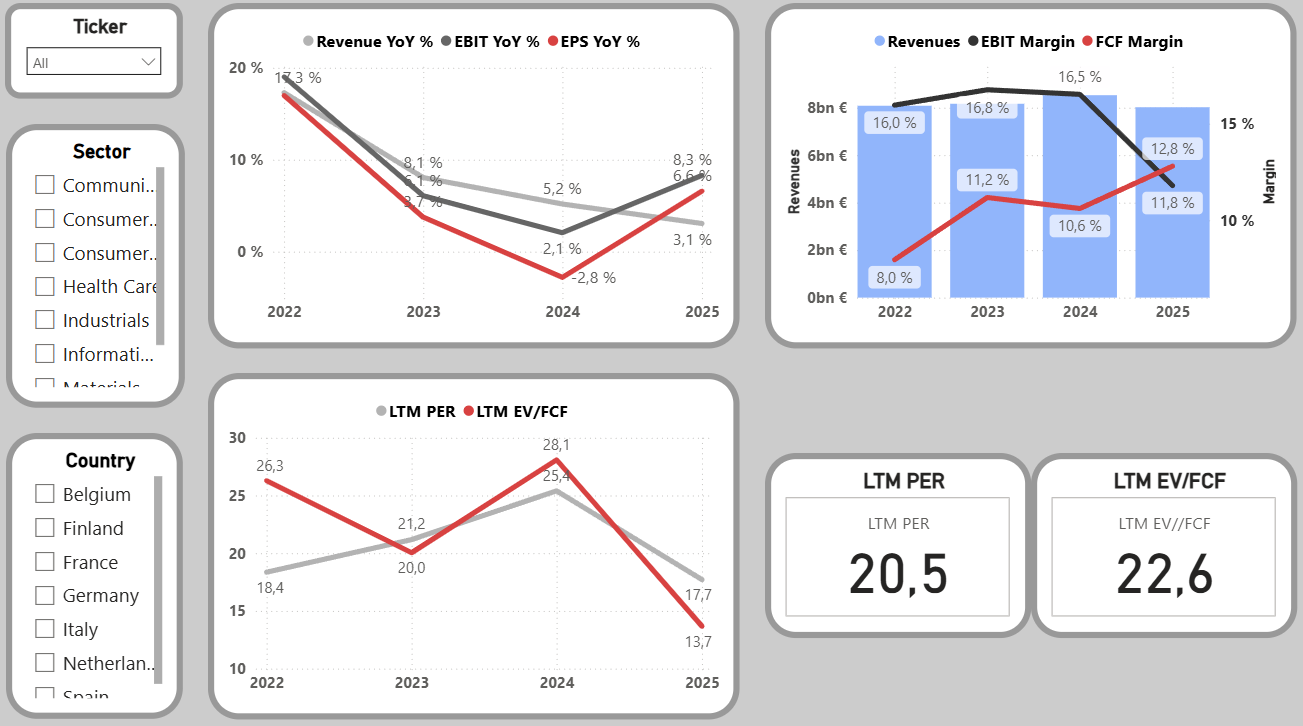Focuses on top-line growth (Revenue) and operational efficiency (EBIT & Net Profit Margins). It also includes LTM valuation multiples (PER, EV/FCF) to assess market pricing relative to performance.

**2. ROIC & Capital Management:** 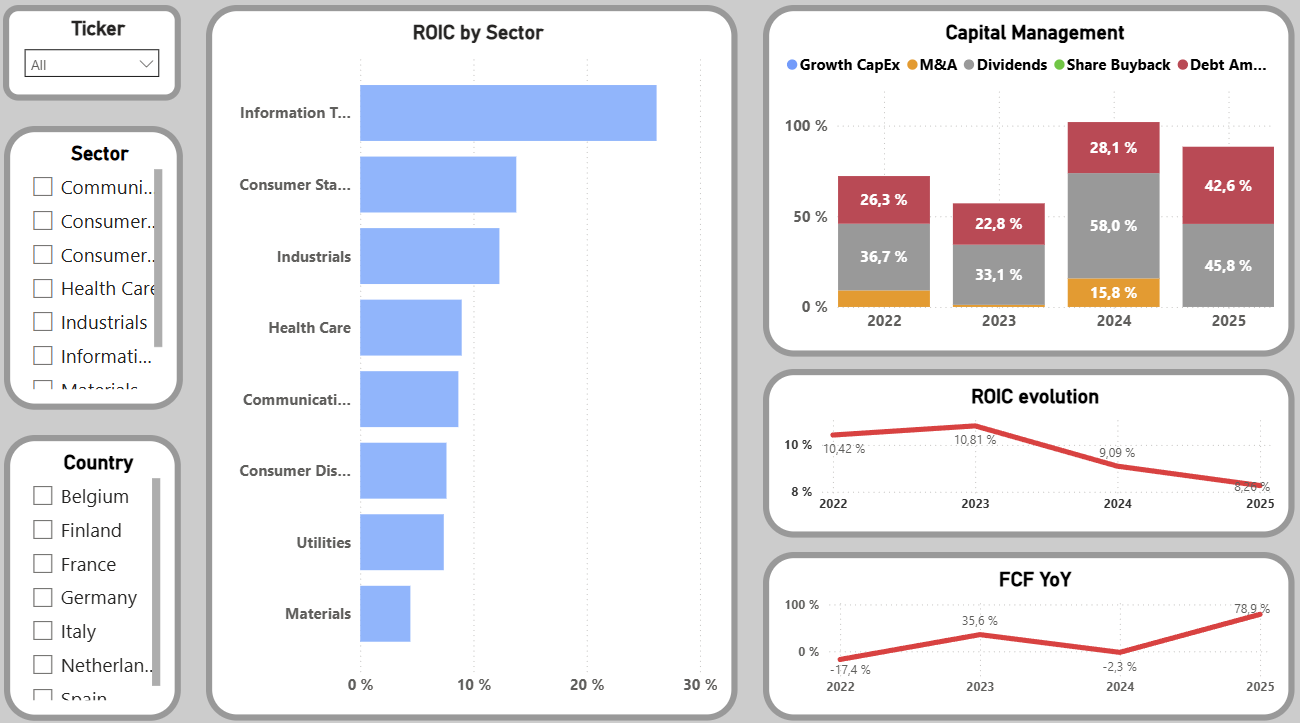Analyzes capital efficiency through ROIC and visualizes cash allocation. It allows users to track how Free Cash Flow is reinvested into the business (Growth CAPEX, M&A) or returned to shareholders (Buybacks, Dividends).

**3. Costs & Debt:** 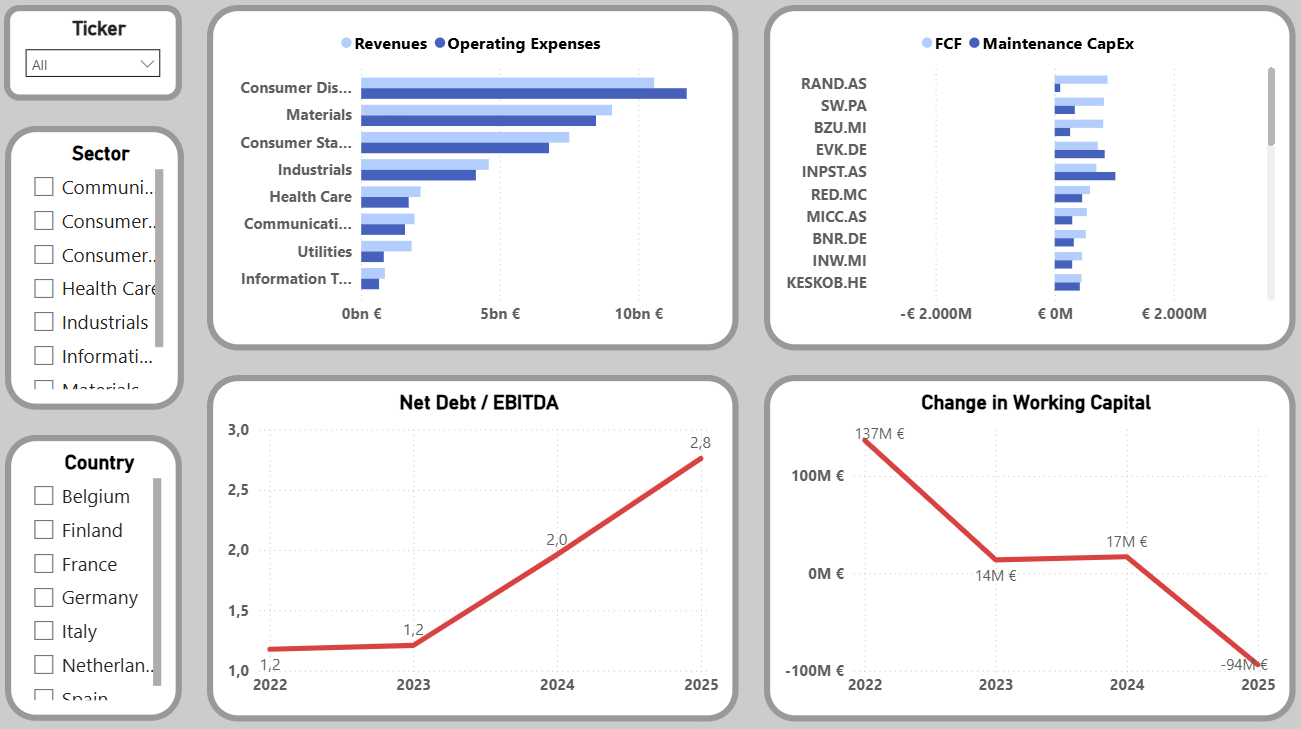Provides a deep dive into operational cost structures (Revenue vs. OPEX) and financial health, focusing on the Net Debt/EBITDA ratio to assess leverage risk.

**7.2 Interactivity & Functionality**

To enhance exploratory analysis, the following features have been implemented:

**Synchronized Slicers:** Sector and Country filters are synchronized across all dashboards, ensuring a consistent view when navigating between pages.

**Contextual Filtering:** Users can filter by sector directly within visual elements to compare peer groups.

**Drill-Down Capability:** Each dashboard supports drilling down from aggregate sector data to individual company levels, displaying all calculated metrics for a specific ticker.

**7.3 Planned Insights Analysis**

The next phase of the project involves utilizing these visualizations to generate actionable insights, specifically focusing on:

Identifying discrepancies between profit margins and cash conversion.

Assessing the sustainability of capital allocation strategies based on FCF trends.

Evaluating debt risk based on the Net Debt/EBITDA ratio across different industries.

##**8. Financial Analysis Insights**

Based on the interactive dashboards, the following trends and insights were identified regarding the dataset comprising companies with market capitalizations under €10 billion (excluding Financials and Real Estate):

**8.1 Market Trends & Valuation**

* **Macroeconomic Environment:** A general reduction in growth rates was observed across the dataset, though a slight positive rebound emerged in 2025. This aligns with a decrease in valuation multiples in the final year, with PER (17x) and EV/FCF (13x) falling below the historical averages of 20x and 22x, respectively.

* **Operating Efficiency:** While EBIT Margins experienced a slight decline, FCF Margins improved. This indicates effective optimization of maintenance CAPEX and improved management of working capital dynamics (inventory, accounts receivable, and accounts payable).

* **Revenue Stability:** Average revenue remains stable but showed a slight decline in 2025, marking the lowest point in the last four years.

**8.2 Sector Analysis**

**High Valuation Sectors (IT & Healthcare):** These sectors command the highest valuation multiples, justified by higher-than-average margins and sustained positive growth.

**Cyclical & Low Valuation Sectors (Materials & Consumer Discretionary):** These sectors exhibit higher financial volatility and lower valuations, typical of cyclical industries.

**Sector Highlights:**


* **Consumer Discretionary:** Showed significant margin expansion, recovering from historically low levels.

* **Consumer Staples:** Experienced a decrease in operating margins.

* **IT:** Boasts the highest ROIC in the dataset, though it declined in the last year due to significant FCF allocation towards M&A.

* **Materials & Consumer Discretionary:** Face high intensity in maintenance CAPEX, requiring a higher percentage of their generated FCF to maintain operations compared to other sectors.

**8.3 Individual Company Analysis & High Performers**

* **RAA.DE (Industrials):** Identified as the top performer in terms of ROIC. The company maintains stable FCF and employs a balanced capital allocation strategy involving dividends, constant M&A, and debt repayment. A substantial divergence between PER (36x) and EV/FCF (10x) in 2023 was explained by a 100% growth in FCF that year, driven by margin expansion from 6% to 9%.

* **FJDU.PA (Consumer Discretionary):** Recorded a high ROIC of 46%. However, a sharp decline from 62% in 2023 to 16% in 2024 was observed, caused by increased debt issuance that raised the Net Debt/EBITDA ratio from -0.5x to 1.9x, increasing invested capital without a corresponding increase in operational efficiency.

* **MICC.AS & LOTB.BR:** Both companies show solid performance with ROICs of 20% and 16%, respectively.

LOTB.BR is notable for a rising ROIC and a focus on organic growth (Growth CAPEX). Its high valuation multiples (70x PER/EVFCF) suggest market expectations of strong future growth.

**8.4 Financial Health & Debt**
* **Leverage Increase:** The Net Debt/EBITDA ratio has increased threefold across the dataset, indicating rising leverage.

* **Working Capital Improvement:** Despite higher leverage, the Working Capital Variation has decreased, suggesting improved operational liquidity and better cash conversion efficiency.

##**9. Final Recommendation: Candidate Analysis**

Based on the quantitative analysis conducted through the dashboards, three companies have been identified for further qualitative investigation. These candidates present distinct profiles regarding growth potential, capital allocation strategies, and current valuation levels.

**9.1 Candidate Profiles**

**1. RAA.DE (Industrials)**
* Profile: High-Quality / Dividend Payer.

* Performance: Demonstrates an impressive ROIC and solid growth trends.

* Investment Case: Highly efficient business model.

**Risks & Considerations**

  * **High Valuation:** Currently trading at 37x (PER and EV/FCF), indicating a very demanding market price.

  * **Capital Allocation:** Primarily utilizes Free Cash Flow for dividend payments rather than reinvesting into growth, suggesting the high ROIC might not be fully leveraged for expansion.

**2. BZU.MI (Materials)**

  * **Profile:** Value / Cash Flow Generator.

  * **Performance:** Solid growth, although subject to high cyclicality inherent to the sector.

  * **Investment Case:** Maintains an acceptable ROIC above the market average and operates with zero debt.

**Risks & Considerations**

  * **Cyclicality:** Vulnerable to commodity price fluctuations.

  * **Capital Allocation:** FCF is dedicated to debt repayment, buybacks, and dividends, indicating a focus on capital return over business growth.

  * **Valuation:** Attractive valuation at 7x but the main objective here is to find out if it's a value trap.

**3. LOTB.BR (Consumer Staples)**

  * **Profile:** Growth / Quality.

  * **Performance:** Solid and consistent growth with a rising ROIC.

  * **Investment Case:** Very low debt levels and a balanced FCF allocation strategy (Growth CapEx, dividends, and debt repayment).

**Risks & Considerations:**

  * **Extreme Valuation:** Currently trading at 70x (PER and EV/FCF). While fundamentals are strong, this valuation requires significant future growth to be justified.